# Optimization with numpy Arrays

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
# note that qutip is NOT imported
%watermark -v --iversions

numpy            1.16.2
matplotlib       3.0.3
krotov           0.3.0+dev
matplotlib.pylab 1.16.2
scipy            1.2.1
CPython 3.6.8
IPython 7.4.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

The `krotov` package heavily builds on QuTiP. However, in rare circumstances
the overhead of `qutip.Qobj` objects might limit numerical efficiency, in
particular when QuTiP's automatic sparse storage is inappropriate. If you know
what you are doing, it is possible to replace `Qobj`s with low-level objects
such as numpy arrays.  This example revisits the [Optimization of a
State-to-State Transfer in a Two-Level-System](01_example_simple_state_to_state.ipynb),
but exclusively uses numpy objects for states and operators.

## Two-level-Hamiltonian

We consider again the standard Hamiltonian of a two-level system, but now we
construct the drift Hamiltonian `H0` and the control Hamiltonian `H1` as numpy
matrices:

In [2]:
def hamiltonian(omega=1.0, ampl0=0.2):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    # .full() converts everything to numpy arrays
    H0 = -0.5 * omega * np.array([[-1, 0], [0, 1]], dtype=np.complex128)
    H1 = np.array([[0, 1], [1, 0]], dtype=np.complex128)

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func="sinsq"
        )

    return [H0, [H1, guess_control]]


In [3]:
H = hamiltonian()

## Optimization target

By default, the `Objective` initializer checks that the objective is expressed with
QuTiP objects. If we want to use low-level objects instead, we have to
explicitly disable this:

In [4]:
krotov.Objective.type_checking = False

Now, we initialize the initial and target states,


In [5]:
ket0 = np.array([[1], [0]], dtype=np.complex128)
ket1 = np.array([[0], [1]], dtype=np.complex128)

and instantiate the `Objective` for the state-to-state transfer:

In [6]:
objectives = [krotov.Objective(initial_state=ket0, target=ket1, H=H)]

objectives

[Objective[a₀[2,1] to a₁[2,1] via [a₂[2,2], [a₃[2,2], u₁(t)]]]]

Note how all objects are numpy arrays, as indicated by the symbol `a`.

## Simulate dynamics under the guess field

To simulate the dynamics under the guess pulse, we can use the objective's
`propagator` method. However, the propagator we use must take into account the
format of the states and operators. We define a simple propagator that solve
the dynamics within a single time step my matrix exponentiation of the
Hamiltonian:

In [7]:
def expm(H, state, dt, c_ops=None, backwards=False, initialize=False):
    eqm_factor = -1j  # factor in front of H on rhs of the equation of motion
    if backwards:
        eqm_factor = eqm_factor.conjugate()
    A = eqm_factor * H[0]
    for part in H[1:]:
        A += (eqm_factor * part[1]) * part[0]
    return scipy.linalg.expm(A * dt) @ state

We will want to analyze the population dynamics, and thus define the projectors
on the ground and excited levels, again as numpy matrices:


In [8]:
proj0 = np.array([[1, 0],[0, 0]], dtype=np.complex128)
proj1 = np.array([[0, 0],[0, 1]], dtype=np.complex128)

We will pass these as `e_ops` to the `propagate` method, but since `propagate`
assumes that `e_ops` contains `Qobj` instances, we will have to teach it how to
calculate expectation values:

In [9]:
def expect(proj, state):
    return complex(state.conj().T @ (proj @ state)).real

Now we can simulate the dynamics over a time grid from $t=0$ to $T=5$ and plot
the resulting dynamics.

In [10]:
tlist = np.linspace(0, 5, 500)

In [11]:
guess_dynamics = objectives[0].propagate(tlist, propagator=expm, e_ops=[proj0, proj1], expect=expect)

In [12]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

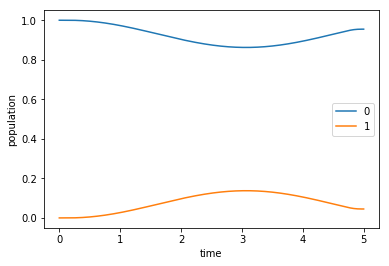

In [13]:
plot_population(guess_dynamics)

The result is the same as in the original example.

## Optimize

First, we define the update shape and step width as before:

In [14]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='sinsq'
    )

In [15]:
pulse_options = {
    H[1][1]: dict(lambda_a=5, shape=S)
}

Now we can run the optimization with only small additional adjustments. This is
because Krotov's method internally does very little with the states and
operators: nearly all of the numerical effort is in the propagator, which we
have already defined above for the specific use of numpy arrays.

Beyond this, the optimization only needs to know three things: First, it must
know how to calculate and apply the operator $\partial H/\partial \epsilon$. We
can easily teach it how to do this:

In [16]:
def mu(objectives, i_objective, pulses, pulses_mapping, i_pulse, time_index):
    def _mu(state):
        return H[1][0] @ state
    return _mu

Second, the pulse updates are calculated from an overlap of states, and we
define an appropriate function for numpy arrays:

In [17]:
def overlap(psi1, psi2):
    return complex(psi1.conj().T @ psi2)

Third, it must know how to calculate the norm of states, for which we can use `np.linalg.norm`.

By passing all these routines to `optimize_pulses`, we get the exact same
results as in the original example, except much faster:

In [18]:
oct_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_re),
    check_convergence=krotov.convergence.check_monotonic_error,
    iter_stop=10,
    norm=np.linalg.norm,
    mu=mu,
    overlap=overlap,
)

  iter.        J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
      0   1.00e+00    0.00e+00   1.00e+00        n/a        n/a     0
      1   7.65e-01    2.33e-02   7.88e-01  -2.35e-01  -2.12e-01     0
      2   5.56e-01    2.07e-02   5.77e-01  -2.09e-01  -1.88e-01     0
      3   3.89e-01    1.66e-02   4.05e-01  -1.67e-01  -1.51e-01     0
      4   2.65e-01    1.23e-02   2.77e-01  -1.24e-01  -1.12e-01     0
      5   1.78e-01    8.63e-03   1.87e-01  -8.68e-02  -7.82e-02     0
      6   1.19e-01    5.86e-03   1.25e-01  -5.89e-02  -5.30e-02     0
      7   8.01e-02    3.91e-03   8.40e-02  -3.92e-02  -3.53e-02     0
      8   5.42e-02    2.58e-03   5.68e-02  -2.59e-02  -2.33e-02     0
      9   3.71e-02    1.70e-03   3.88e-02  -1.71e-02  -1.54e-02     0
     10   2.58e-02    1.13e-03   2.70e-02  -1.13e-02  -1.02e-02     0


In [19]:
oct_result

Krotov Optimization Result
--------------------------
- Started at 2019-04-21 18:33:30
- Number of objectives: 1
- Number of iterations: 10
- Reason for termination: Reached 10 iterations
- Ended at 2019-04-21 18:33:33